In [21]:
%load_ext autoreload
%autoreload 2
import os
import sys
import importlib
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
from tqdm import tqdm
from joblib import Parallel, delayed
from itertools import product
from collections import defaultdict
import matplotlib.pyplot as plt

# 设定项目根目录
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

# 导入模型
from src.Bayesian_recon import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import src.Bayesian_recon.problems.model as model
from src.Bayesian_recon.problems.model import StandardModel as Model

import src.Bayesian_recon.problems.config as config
from src.Bayesian_recon.problems.config import config_fgt

from src.Bayesian_recon.problems import *

from src.Bayesian_recon.utils.optimizer import Optimizer

In [31]:
def post_acc_amount_f(x):
    if x <= 0.2:
        return 0
    elif 0.2 < x < 0.3:
        return 1
    elif 0.3 <= x < 0.4:
        return 2
    elif 0.4 <= x < 0.5:
        return 3
    elif 0.5 <= x < 0.6:
        return 4
    elif 0.6 <= x < 0.7:
        return 5
    elif 0.7 <= x < 0.8:
        return 6
    elif 0.8 <= x <= 1:
        return 7

def random_acc_amount_f(x):
    return 7 - post_acc_amount_f(x)


module_config = {
    "cluster": (PartitionCluster, {
        "transition_spec":
        [(PartitionCluster._amount_accuracy_gen(post_acc_amount_f,
                                                7), "top_posterior"),
         (1, "ksimilar_centers"),
         (PartitionCluster._amount_accuracy_gen(random_acc_amount_f,
                                                7), "random")]})
    # ,
    # "memory": (BaseMemory, {
    #     "personal_memory_range": {
    #         "gamma": (0.05, 1.0),
    #         "w0": (0.075, 0.15)
    #     },
    #     "param_resolution": 20
    # })
}
optimizer = Optimizer(module_config, n_jobs=100)

# 导入数据
processed_path = Path(project_root) / 'data' / 'processed'
optimizer.prepare_data(processed_path / 'Task2_processed.csv')

Error initializing module cluster: 'Optimizer' object has no attribute 'partition_model'


In [ ]:
# 加载拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_recon'
cluster_results = joblib.load(result_path / 'M_fgt_cl_random7_randp_k3.joblib')

best_params_list = [
    result['best_params'] for result in cluster_results.values()
]
gamma_values = [params['gamma'] for params in best_params_list]
w0_values = [params['w0'] for params in best_params_list]

In [ ]:
res = optimizer.optimize_params_with_mcmc(
    config_fgt, gamma_values, w0_values, [1])
# list(range(1, 25)))

[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
Subject 1 MCMC:  28%|████████████▎                               | 281/1000 [07:08<18:13,  1.52s/it]

In [ ]:
res = optimizer.optimize_params_with_subs_parallel(
    config_fgt, [1])
    # list(range(1, 25)))

Processing tasks: 100%|█████████████████████████████████████████| 400/400 [1:56:10<00:00, 17.43s/it]


In [ ]:
# 保存拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_recon'
os.makedirs(result_path, exist_ok=True)

joblib.dump(res, result_path / 'M_fgt_cluster_random4.joblib')

In [5]:
# 加载拟合结果
result_path = Path(project_root) / 'results' / 'Bayesian_recon'
cluster_results = joblib.load(result_path / 'M_fgt_cl_acc7_randp_k3.joblib')

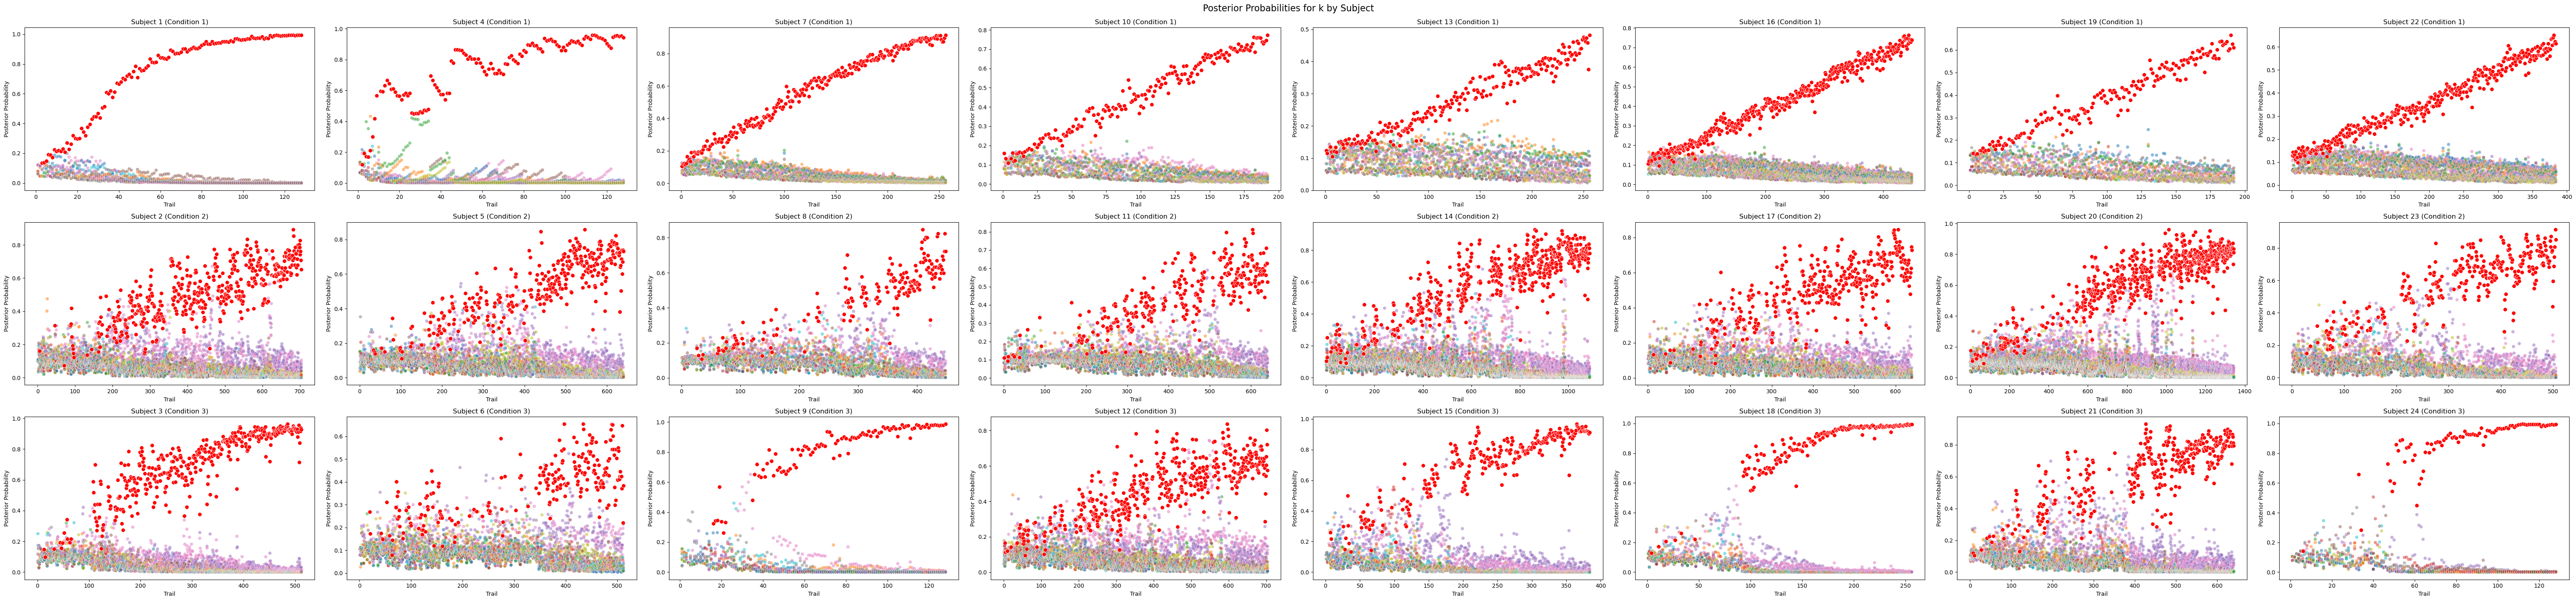

In [6]:
optimizer.plot_posterior_probabilities(
    cluster_results,
    range(1,25), save_path=result_path/'M_fgt_cl_acc7_randp_k3_post.png')

In [7]:
optimizer.set_results(cluster_results)
prediction = optimizer.predict_with_subs_parallel(
    config_fgt,
    range(1,25))

Predicting tasks: 100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 31126.56it/s]


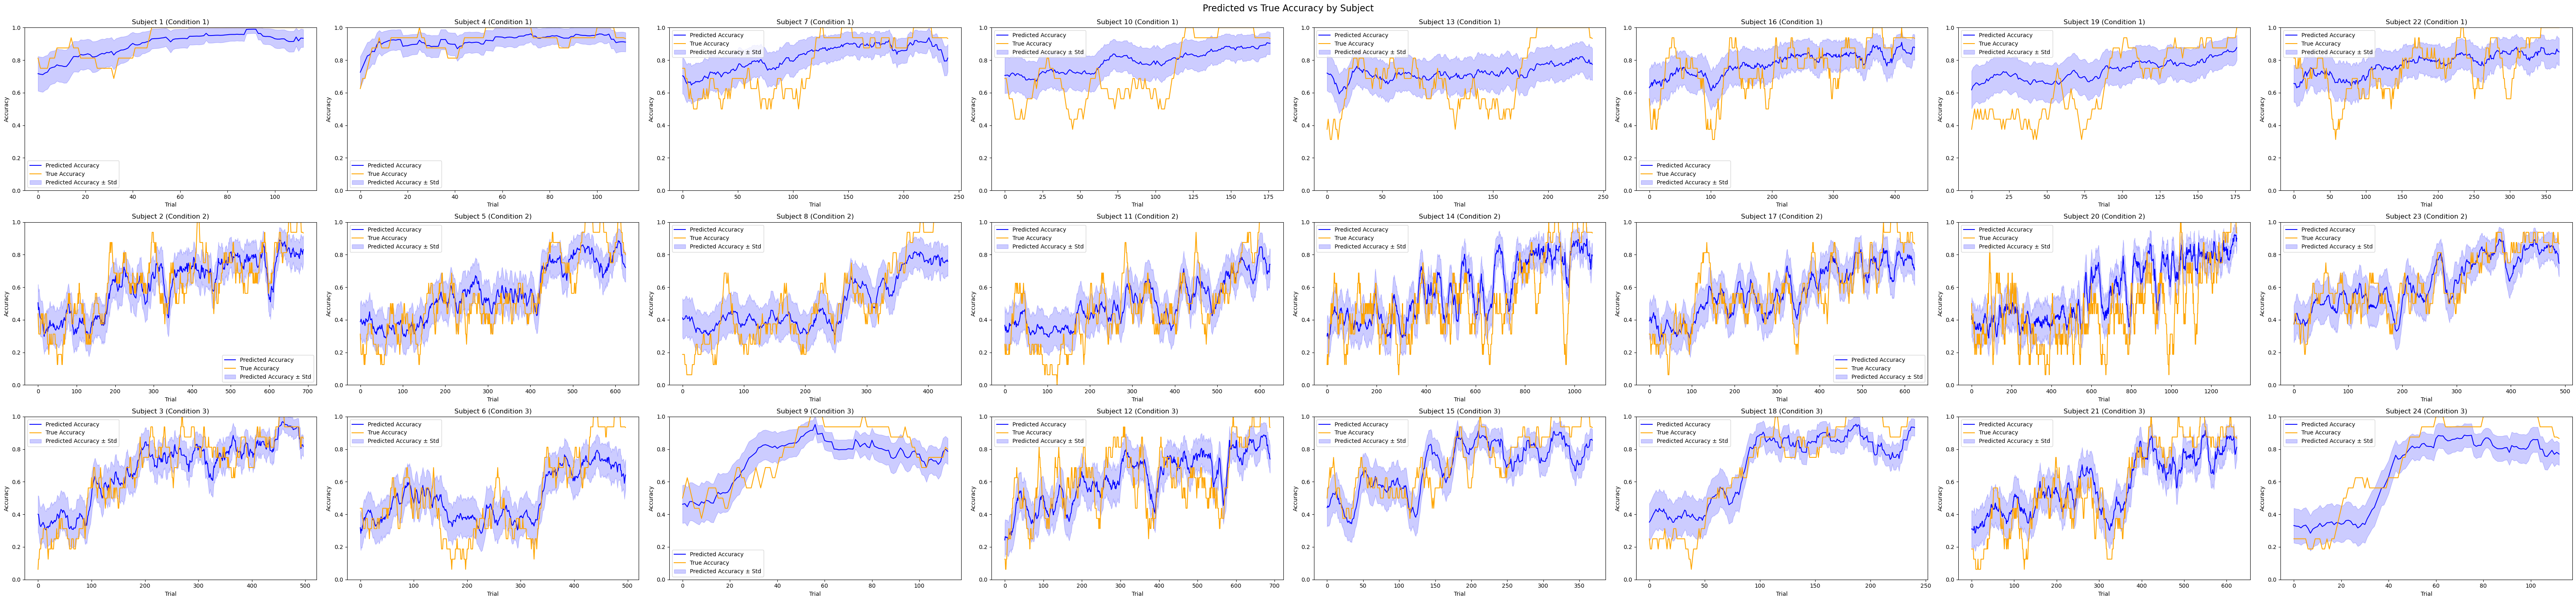

In [8]:
optimizer.plot_accuracy_comparison(prediction, save_path=result_path/'M_fgt_cl_acc7_randp_k3_acc.png')

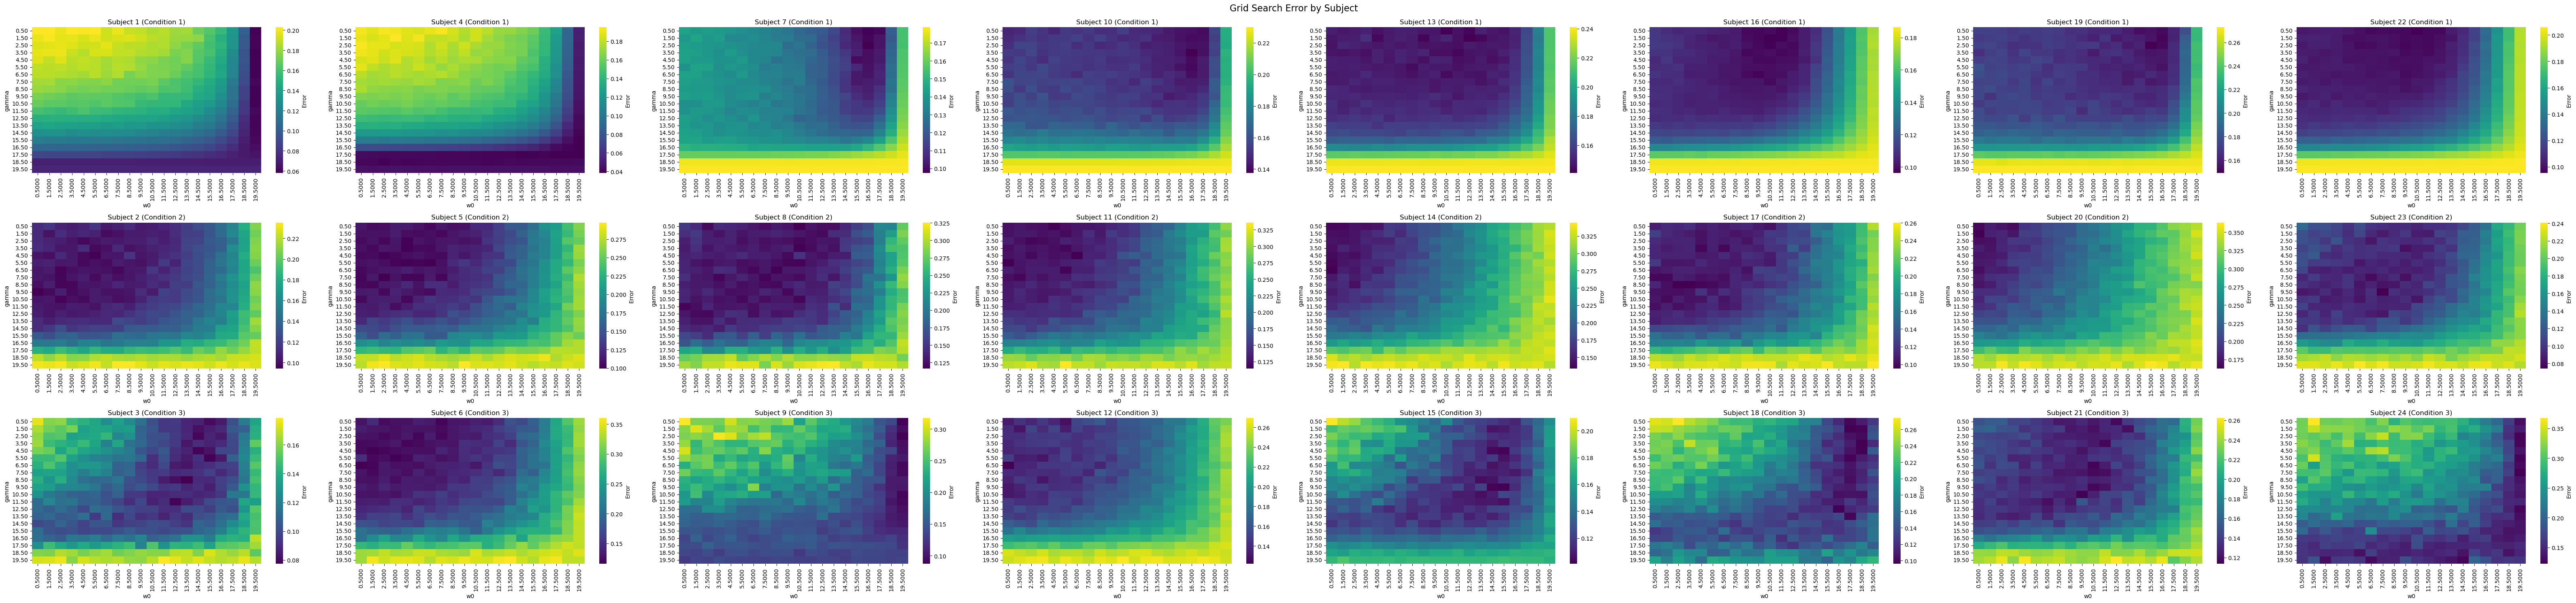

In [9]:
optimizer.plot_error_grids(cluster_results, save_path=result_path/'M_fgt_cl_acc7_randp_k3_grid.png')

####  q

In [ ]:
from pathlib import Path
import joblib

# 获取所有带有指定前缀的文件
files_to_merge = list(result_path.glob("M_fgt_cl_*.joblib"))

# 合并文件内容
merged_data = {}
for file in files_to_merge:
    data = joblib.load(file)
    merged_data.update(data)

# 保存合并后的文件
output_file = result_path / "M_fgt_cl.joblib"
joblib.dump(merged_data, output_file)

print(f"Merged file saved to {output_file}")